## note on 2020.3.2
-  this ipynb is used for testing local_data_to_motion_vector.py

In [1]:
import os
import numpy as np
import glob
from datetime import datetime,timedelta
#from rainymotion import models, metrics, utils
from time import time
import cv2
import matplotlib.pyplot as plt
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import joblib 

t0 = time()
print(os.getcwd())
data_folder = "/Users/jiang/data/kakuho_dev"
bin_files = glob.glob(os.path.join(data_folder,"*ints.1km.bin"))  # 288 = 12*24
bin_files.sort()
now_files = bin_files[-2:]
print(*now_files, sep = "\n")
datetime_str = now_files[-1].split("/")[-1].split(".")[0]
datetime_object = datetime.strptime(datetime_str,"%Y%m%d%H%M")
print(datetime_object)

time_step = 5 * 60 # seconds
inputs = np.zeros(shape = (2,3360,2560), dtype = np.float32)
for i, bin_file in enumerate(now_files):
    inputs[i] = np.fromfile(bin_file, dtype = "float32").reshape((3360,2560))

mask = inputs[0] < 0
inputs[inputs < 0] = 0
X_dbz = np.log10(inputs + 0.01)
c1 = X_dbz.min()
c2 = X_dbz.max()
data_scaled = ((X_dbz - c1) / (c2 - c1) * 255).astype(np.uint8)

delta = cv2.optflow.createOptFlow_DIS().calc(data_scaled[0], data_scaled[1], None)

u = ma.array(data = delta[:,:,0], mask = mask)
v = ma.array(data = delta[:,:,1], mask = mask)

/Users/jiang/github_all/rainymotion/docs/notebooks
/Users/jiang/data/kakuho_dev/202002270540.prec.ints.1km.bin
/Users/jiang/data/kakuho_dev/202002270545.prec.ints.1km.bin
2020-02-27 05:45:00


In [4]:
mask.shape

(3360, 2560)

In [5]:
3360*2560 - np.sum(mask)

2573233

In [9]:
bin_files[-14:-12]

['/Users/jiang/data/kakuho_dev/202002270440.prec.ints.1km.bin',
 '/Users/jiang/data/kakuho_dev/202002270445.prec.ints.1km.bin']

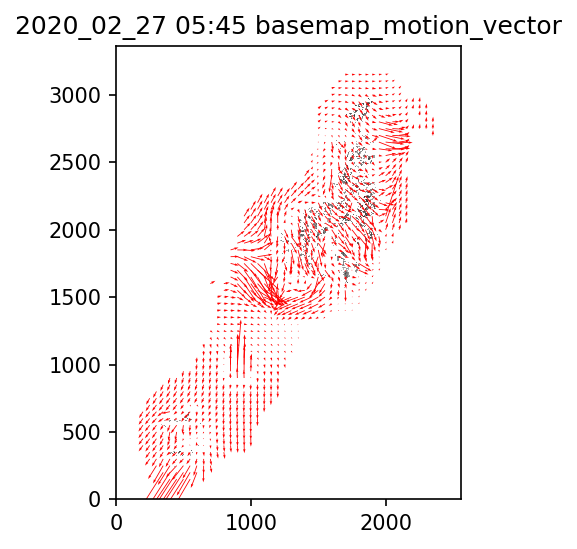

In [3]:
# plot motion vector
plt.figure(dpi = 150)
plt.imshow(data_scaled[-1], cmap = "gray_r",origin = "lower")
X,Y = range(2560),range(3360)
skip = 50
plt.quiver(X[::skip], Y[::skip], u[::skip,::skip], v[::skip,::skip],
           scale = 100,color='red',headwidth = 3)
#plt.savefig(f"{datetime_str}_motion_vector.png",format = "png",bbox_inches='tight')
#plt.close()
plt.title(f"{datetime_object.strftime('%Y_%m_%d %H:%M ')}basemap_motion_vector")
plt.show()

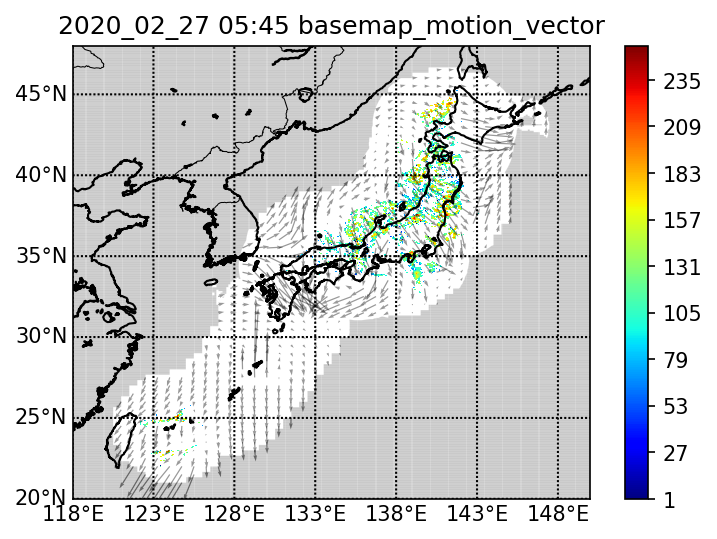

In [4]:
# lon, lat = joblib.load("JMA_radar_lon_lat.joblib")
lon = np.linspace(118.00625, 149.99375, 2560)
lat = np.linspace(20.004167, 47.995833, 3360)
plt.figure(dpi=150)
m = Basemap(llcrnrlat=20,urcrnrlat=48, llcrnrlon=118, urcrnrlon=150,resolution = "i")
lons, lats = np.meshgrid(lon, lat)
m.contourf(lons, lats, data_scaled[-1], levels=list(range(1,255)),cmap='jet' )
m.drawcoastlines(color='black')
m.drawcountries()
m.drawmeridians(np.arange(118, 150, 5), labels=[1,0,0,1])# left, right, top or bottom
m.drawparallels(np.arange(20, 48, 5), labels=[1,0,1,0])
plt.colorbar()
x,y = m(lon, lat)
skip = 60
plt.quiver(x[::skip], y[::skip], u[::skip,::skip], v[::skip,::skip], scale = 100,  headwidth = 3, alpha = 0.4)
m.pcolormesh(lons, lats, mask, cmap= "binary", alpha=0.002)
plt.title(f"{datetime_object.strftime('%Y_%m_%d %H:%M ')}basemap_motion_vector")
plt.show()

In [60]:
ma.concatenate((u, v), axis=0)

(6720, 2560)

In [65]:
u.data.tofile("ok.bin")

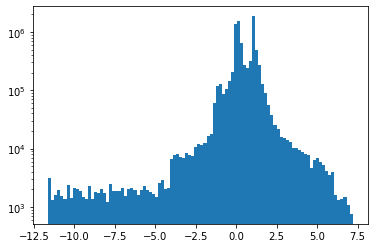

In [70]:
plt.hist(np.fromfile("ok.bin", dtype = "float32"),100)
plt.yscale("log")
plt.show()

In [5]:
3360*2560

8601600

# advection result

In [17]:
import os
import numpy as np
import glob
from datetime import datetime,timedelta
from rainymotion import models, metrics, utils
from time import time
import cv2
import matplotlib.pyplot as plt
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import joblib 

t0 = time()
print(os.getcwd())
data_folder = "/Users/jiang/data/kakuho_dev"  ## in local computer 
output_folder = "./output_vector"
if not os.path.exists(data_folder):
	data_folder = "../../../usr/amoeba/pub/rain_kakuho/hres.jma_nowcast/out"
bin_files = glob.glob(os.path.join(data_folder,"*ints.1km.bin"))  # 288 = 12*24
bin_files.sort()
now_files = bin_files[-14:-12]
truth_file = bin_files[-1]
print(*now_files, sep = "\n")
print(truth_file)

datetime_str = now_files[-1].split("/")[-1].split(".")[0]
datetime_object = datetime.strptime(datetime_str,"%Y%m%d%H%M")
print(datetime_object)

threshold = 0.1
inputs = np.zeros(shape = (2,3360,2560), dtype = np.float32)
for i, bin_file in enumerate(now_files):
	inputs[i] = np.fromfile(bin_file, dtype = "float32").reshape((3360,2560))
mask = inputs[0] < 0
inputs[inputs < 0] = 0

gt_in_60_min = np.fromfile(truth_file, dtype = "float32").reshape((3360,2560))
gt_in_60_min[gt_in_60_min<0] = 0

model = models.Dense60()
model.input_data = inputs
prediciton = model.run()
threat = metrics.CSI(gt_in_60_min[~mask], prediciton[~mask], threshold = threshold)

print(f"threat = {threat:.2f}")

/Users/jiang/github_all/rainymotion/docs/notebooks
/Users/jiang/data/kakuho_dev/202002270440.prec.ints.1km.bin
/Users/jiang/data/kakuho_dev/202002270445.prec.ints.1km.bin
/Users/jiang/data/kakuho_dev/202002270545.prec.ints.1km.bin
2020-02-27 04:45:00
threat = 0.21


In [24]:
np.sum(gt_in_60_min>= threshold), np.sum(gt_in_60_min>= threshold)/np.sum(~mask)

(77589, 0.030155388338703903)

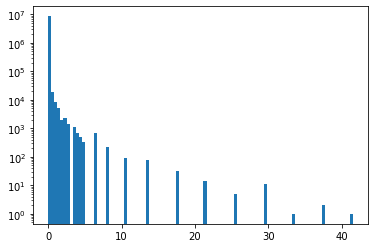

In [13]:
plt.hist(gt_in_60_min.flatten(), 100)
plt.yscale("log")
plt.show()

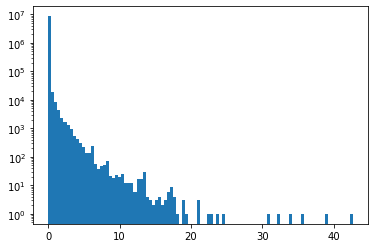

In [14]:
plt.hist(prediciton.flatten(), 100)
plt.yscale("log")
plt.show()

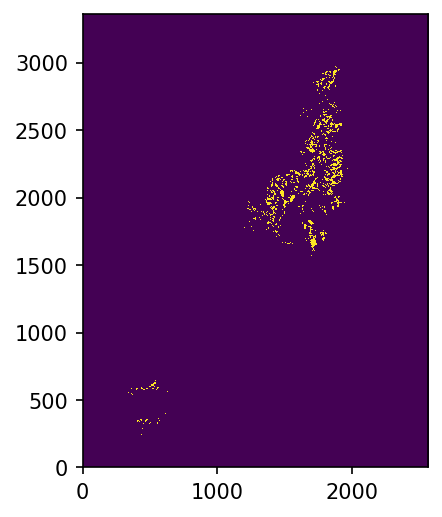

In [9]:
plt.figure (dpi = 150)
plt.imshow(gt_in_60_min>= threshold, origin = "lower")
plt.show()

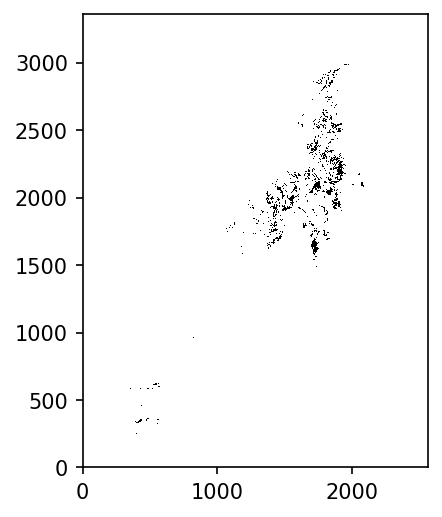

In [10]:
plt.figure (dpi = 150)
plt.imshow(prediciton>= threshold, cmap = "binary", origin = "lower")
plt.show()